# KGAP-LINCS-IDG: ROC AUC validation vs DrugCentral PD genes

## Imports
Install neo4j library if you don't already have it.

In [1]:
try:
  import neo4j
except:
  !pip install neo4j
  import neo4j

     |████████████████████████████████| 71kB 2.0MB/s 
  Created wheel for neo4j: filename=neo4j-4.1.1-cp36-none-any.whl size=94668 sha256=a836a1867fae3257dbc1604cc86b94ed44ddab22cb200f49c80eaf01ec667758
  Stored in directory: /root/.cache/pip/wheels/9a/fc/33/6d01e37785f45eb8f7b6d1c95db82eb0c4816d465205c1dfa9
Successfully built neo4j


In [2]:
import pandas as pd, pandas.io.sql
import base64, requests, getpass
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, matthews_corrcoef, f1_score
from matplotlib import pyplot as plt
import psycopg2, psycopg2.extras

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Connect to DrugCentral 

In [3]:
dbhost="unmtid-dbs.net"; dbport=5433; dbname="drugcentral"; dbusr="drugman"; dbpw="dosage";
dsn = ("host='%s' port='%s' dbname='%s' user='%s' password='%s'"%(dbhost, dbport, dbname, dbusr, dbpw))
dbcon = psycopg2.connect(dsn)
dbcon.cursor_factory = psycopg2.extras.DictCursor

## Query DrugCentral for PD genes

In [4]:
sql="""\
SELECT DISTINCT
        atf.target_name,
        atf.gene genes,
        atf.moa
FROM
        act_table_full atf
JOIN
        structures s ON s.id = atf.struct_id
JOIN
        omop_relationship omop ON omop.struct_id = s.id
WHERE
        omop.relationship_name = 'indication'
        AND omop.concept_name ~* 'Parkinson'
"""
dcgenes = pandas.io.sql.read_sql_query(sql, dbcon)
dcgenes = dcgenes.astype({'moa': 'boolean'})
dcgenes.head()

,target_name,genes,moa
0,5-hydroxytryptamine receptor 1A,HTR1A,<NA>
1,5-hydroxytryptamine receptor 1A,Htr1a,<NA>
2,5-hydroxytryptamine receptor 1B,HTR1B,<NA>
3,5-hydroxytryptamine receptor 1B,Htr1b,<NA>
4,5-hydroxytryptamine receptor 1D,HTR1D,<NA>


## Parse and split delimited gene symbols to separate rows:

In [5]:
b = pd.DataFrame(dcgenes.genes.str.split('|').tolist(), index=dcgenes.index).stack()
b = pd.DataFrame(b)
b.columns = ['gene']
print("0-level index: {}".format(b.index.levels[0]))
b.head()
b = b.reset_index(level=1, drop=True)
b.head()

0-level index: RangeIndex(start=0, stop=120, step=1)


,gene
0,HTR1A
1,Htr1a
2,HTR1B
3,Htr1b
4,HTR1D


In [6]:
dcgenes = dcgenes.drop(columns=["genes"]).join(b, how="left")
dcgenes.head(12)

,target_name,moa,gene
0,5-hydroxytryptamine receptor 1A,<NA>,HTR1A
1,5-hydroxytryptamine receptor 1A,<NA>,Htr1a
2,5-hydroxytryptamine receptor 1B,<NA>,HTR1B
3,5-hydroxytryptamine receptor 1B,<NA>,Htr1b
4,5-hydroxytryptamine receptor 1D,<NA>,HTR1D
5,5-hydroxytryptamine receptor 2A,True,HTR2A
6,5-hydroxytryptamine receptor 2A,<NA>,HTR2A
7,5-hydroxytryptamine receptor 2B,<NA>,HTR2B
8,5-hydroxytryptamine receptor 2C,True,HTR2C
9,5-hydroxytryptamine receptor 2C,<NA>,HTR2C


## Query DrugCentral for PD drugs 

In [8]:
sql = """\
SELECT DISTINCT
	ids.identifier AS pubchem_cid,
	s.id,
	s.name,
	atc.l1_code,
	atc.l1_name,
	omop.concept_name omop_concept_name,
	omop.snomed_full_name
FROM
	omop_relationship omop
JOIN
	structures s ON omop.struct_id = s.id
JOIN
	identifier ids ON ids.struct_id = s.id
JOIN
	struct2atc s2atc ON s2atc.struct_id = s.id
JOIN
	atc ON atc.code = s2atc.atc_code
WHERE
	ids.id_type = 'PUBCHEM_CID'
	AND atc.l1_name = 'NERVOUS SYSTEM'
	AND omop.relationship_name = 'indication'
"""
df = pandas.io.sql.read_sql_query(sql, dbcon)
df.head()

,pubchem_cid,id,name,l1_code,l1_name,omop_concept_name,snomed_full_name
0,3036780,4115,asenapine,N,NERVOUS SYSTEM,Schizophrenia,Schizophrenia
1,3446,1264,gabapentin,N,NERVOUS SYSTEM,Postherpetic neuralgia,Postherpetic neuralgia
2,4021,4156,edaravone,N,NERVOUS SYSTEM,Ischemic stroke,Ischemic stroke
3,3821,1523,ketamine,N,NERVOUS SYSTEM,Local anesthesia,Local anesthesia
4,4158,1767,methylphenidate,N,NERVOUS SYSTEM,Narcolepsy,Narcolepsy


In [11]:
print("PUBCHEM_CIDs: {}".format(",".join(list(df.pubchem_cid))))

PUBCHEM_CIDs: 3036780,3446,4021,3821,4158,2206,5002,55191,26757,4909,3676,208902,2726,15130,4099,5284627,3016,5411,3372,2712,3676,3672,1935,3386,8271,5002,3000322,2337,135565903,3559,2474,5361092,3117,5284371,60795,1547484,1775,4601,9690109,3958,9690109,10071196,33741,3000322,3345,3345,6918314,4919,32170,4060,2337,3016,5311454,1201549,5193,4062,38668,2554,4744,3059,3686,3180,8223,5360515,43815,4940,3299,2519,54746,4744,5281081,47811,3000322,60835,60815,3386,2519,3025,5284371,4737,5360696,65833,2337,1983,5002,5361092,4926,16363,4099,5284583,4909,338,4506,4914,4926,5284603,667477,4054,5284371,131682,54841,3696,5284596,3676,4158,2381,1983,129228,5360696,3345,3016,5360696,3672,1983,4744,996,4909,2244,3658,5360515,16362,60854,2712,3396,5568,441278,4919,5360696,2118,3121,3958,135398737,4917,11125,6047,3672,2712,92253,10220503,2118,2712,4737,8223,4748,3958,10836,3331,5284583,3025,5288826,5284371,5910,3291,2244,6488,3016,1775,3958,4926,92253,3000715,4926,60795,3658,89594,4744,338,121892,969010

## Connect to Neo4j and test to confirm connection.

In [12]:
NeoUser = "mrsmith"
NeoPasswrd = getpass.getpass()

··········


In [13]:
uri = "neo4j://hoffmann.data2discovery.net:7695"
db = neo4j.GraphDatabase.driver(uri, auth= (NeoUser, NeoPasswrd))
session = db.session()

## Functions for ROC curves
Given a cypher query return a *dataframe*



In [14]:
def cypher2df(cql):
    df = pd.DataFrame(session.run(cql).data())
    return(df)

From results and a validation geneset "valgenes", plot ROC curve with AUC.
  * Column header for the validation genes defaults to "name"
  * Column header for the cypher gene names defaults to "g.name"
  * Column header for the cypher centrality defaults to "sc"
 but can be changed with the variables "vgname", "cyname" and "cqlsc", respectively

In [15]:
def ROCplotter(cdf, valgenes, vgname = "name", cyname = 'g.name', cqlsc = 'score', show_mcc=False):
    vga = np.array(cdf[cyname].isin(valgenes[vgname]).astype(np.int8))
    fpr, tpr, thresholds = roc_curve(vga, np.array(cdf[cqlsc]))
    auctest = roc_auc_score(vga, np.array(cdf[cqlsc]))
    plt.figure(figsize=(7,5), dpi=100)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = 'ROC curve (area = %0.2f)' % auctest)
    plt.plot([0,1], [0,1], color ='blue', lw=1, linestyle='--')
    if show_mcc:
      mcc = [matthews_corrcoef(vga, cdf[cqlsc]>=t) for t in thresholds]
      plt.plot(fpr, mcc, color='gray', lw=1, label = 'MCC (max={:.3f})'.format(max(mcc)))
    plt.legend(loc="lower right")
    return fpr, tpr, thresholds

## Specify Cypher query and run ROCplotter validation geneset.



In [16]:
score_attribute = "sum(r.zscore)/sqrt(count(r))"  # sumz()
cid_list = list(df.pubchem_cid.array.astype('int'))
cql = """\
MATCH p=(d:Drug)-[]-(s:Signature)-[r]-(g:Gene), p1=(s)-[]-(c:Cell)
WHERE (d.pubchem_cid in {})
WITH g, {} AS score
RETURN g.id, g.name, score
ORDER BY score DESC
""".format(cid_list, score_attribute)

## DrugCentral PD indication target geneset

In [17]:
print("DrugCentral PD indication genes: {}; +MoA: {}".format(dcgenes.shape[0], dcgenes[(dcgenes.moa)].shape[0]))
dcgenes.head()

DrugCentral PD indication genes: 173; +MoA: 35


,target_name,moa,gene
0,5-hydroxytryptamine receptor 1A,<NA>,HTR1A
1,5-hydroxytryptamine receptor 1A,<NA>,Htr1a
2,5-hydroxytryptamine receptor 1B,<NA>,HTR1B
3,5-hydroxytryptamine receptor 1B,<NA>,Htr1b
4,5-hydroxytryptamine receptor 1D,<NA>,HTR1D


In [18]:
hitgenes = cypher2df(cql)
hitgenes.head()

,g.id,g.name,score
0,10320,IKZF1,182.045567
1,4208,MEF2C,170.692172
2,6696,SPP1,164.938151
3,7048,TGFBR2,164.064284
4,4638,MYLK,163.562887


In [19]:
print("Score range: [{:.1f}, {:.1f}]; mean: {:.1f}; median: {:.1f}".format(min(hitgenes.score), max(hitgenes.score), np.mean(hitgenes.score), np.median(hitgenes.score)))


Score range: [-165.3, 182.0]; mean: 8.6; median: 11.9


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


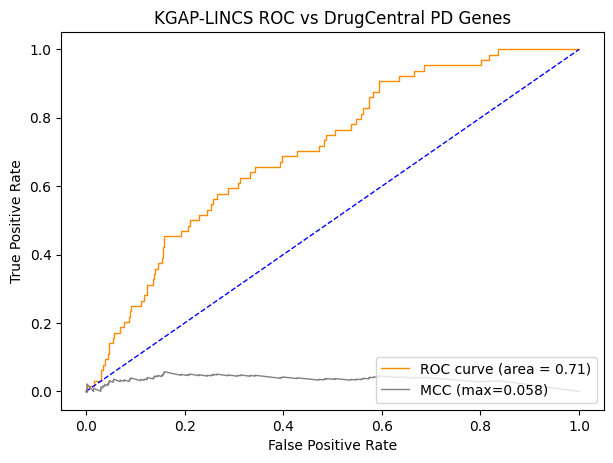

In [20]:

fpr, tpr, thresholds = ROCplotter(hitgenes, dcgenes, vgname="gene", cqlsc="score", show_mcc=True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KGAP-LINCS ROC vs DrugCentral PD Genes')
plt.show()

In [21]:
thresholds

array([ 183.04556682,  182.04556682,  127.22608112,  127.16325633,
         63.16870191,   63.08350937,   39.0341466 ,   39.01048168,
         38.83252179,   38.81017283,   36.47058934,   36.43791837,
         35.18950657,   35.15903961,   33.90754598,   33.90147842,
         33.49281735,   33.47264765,   33.2708138 ,   33.2625319 ,
         32.13307664,   32.12145001,   31.98584974,   31.97192446,
         30.55857649,   30.54766302,   29.90203203,   29.89224668,
         29.12281083,   29.12179443,   29.0521369 ,   29.05076625,
         28.8820952 ,   28.8803123 ,   27.62664324,   27.62392616,
         27.26868819,   27.26310672,   26.92000966,   26.91968286,
         26.88711867,   26.88595271,   26.33977072,   26.33964898,
         26.28361806,   26.28083902,   26.18213534,   26.16969806,
         25.80373873,   25.79644415,   25.35256276,   25.348146  ,
         25.30067219,   25.29954638,   25.19662423,   25.19644261,
         25.12751412,   25.12463373,   25.1246043 ,   25.11648

MoA genes only:

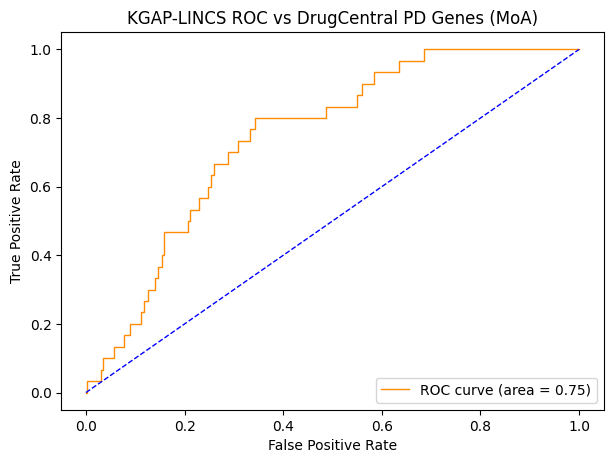

In [22]:
ROCplotter(hitgenes, dcgenes[(dcgenes.moa)], vgname="gene", cqlsc="score")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KGAP-LINCS ROC vs DrugCentral PD Genes (MoA)')
plt.show()